In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import holidays
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error as mape
import optuna
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from scipy.stats import pointbiserialr
from sklearn.preprocessing import LabelEncoder

custom_palette = sns.color_palette('Set1')

plt.rcParams.update({'figure.figsize' : (15,8), 'figure.dpi' : 300, 'axes.grid' : True})

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
warnings.filterwarnings("ignore")

* __Adding hourly weather data as an external data__
* __Adding med data which corresponds to Major Event Day__
* __Adding dates of Turkey's holidays__

In [9]:
izmir_hava = pd.read_csv('izmir_hava.csv')
manisa_hava = pd.read_csv('manisa_hava.csv')

holidays = pd.read_csv('holidays.csv')
med = pd.read_csv('OG_DATA/med.csv')
test = pd.read_csv('OG_DATA/sample_submission.csv')
train = pd.read_csv('OG_DATA/train.csv')

__I selected best features using Sequential Forward Selection algorithm. Process took approximately 15-20 minutes, hence it is not included here. But I will import that data to use the column names later.__

In [10]:
izmir_sfs = pd.read_csv('izmir_sfs20.csv')
sfs_columns = izmir_sfs.columns.to_list()

In [11]:
train.Tarih = pd.to_datetime(train.Tarih)
test.Tarih = pd.to_datetime(test.Tarih)

train['is_test'] = 0
test['is_test'] = 1

## Feature Engineering

__%85 of the usage is from İzmir and the rest is from Manisa. I will separate them to be able to use their own weather data.__

In [12]:
izmir = train.copy()
manisa = train.copy()

izmir['Dağıtılan Enerji (MWh)'] = izmir['Dağıtılan Enerji (MWh)'] * 0.85
manisa['Dağıtılan Enerji (MWh)'] = manisa['Dağıtılan Enerji (MWh)'] * 0.15

izmir = pd.concat([izmir,test])

manisa = pd.concat([manisa,test])

In [13]:
izmir

,Tarih,Dağıtılan Enerji (MWh),is_test
0,2018-01-01 00:00:00,1354.852583,0
1,2018-01-01 01:00:00,1286.843804,0
2,2018-01-01 02:00:00,1192.220741,0
3,2018-01-01 03:00:00,1086.748176,0
4,2018-01-01 04:00:00,1037.593046,0
...,...,...,...
739,2022-08-31 19:00:00,0.000000,1
740,2022-08-31 20:00:00,0.000000,1
741,2022-08-31 21:00:00,0.000000,1
742,2022-08-31 22:00:00,0.000000,1


__Adding calendar features, categoric variables of med data, holidays and also for covid period.__

In [14]:
def date_extractor(df):
    
    df.Tarih = pd.to_datetime(df.Tarih)
    
    season_map = {12: 1, 1: 1, 2: 1,
              3: 2, 4: 2, 5: 2,
              6: 3, 7: 3, 8: 3,
              9: 0, 10: 0, 11: 0}
    
    
    df['year'] = df.Tarih.dt.year
    df['month'] = df.Tarih.dt.month
    df['day'] = df.Tarih.dt.day
    df['hour'] = df.Tarih.dt.hour
    df['day_ofweek'] = df.Tarih.dt.dayofweek
    df['is_weekend'] = df.day_ofweek.apply(lambda x: 1 if x >= 5 else 0)
    df['weekofyear'] = df.Tarih.dt.weekofyear
    df['day_ofyear'] = df.Tarih.dt.dayofyear
    df['quarter'] = df.Tarih.dt.quarter
    df['season'] = df.month.map(season_map)
    df['is_leap'] = df.Tarih.dt.is_leap_year.replace({False : 0, True : 1})
    
    df.set_index('Tarih',inplace=True)
    
    df['is_med'] = 0
    for medday in med.Tarih.values:
        df['is_med'].loc[df.loc[medday].index] = 1
        
    df['is_holiday'] = 0
    for holiday in holidays[:-1].Tarih.values:
        df['is_holiday'].loc[df.loc[holiday].index] = 1
    
    
    df['is_covid'] = 0
    df['is_covid'].loc[df['2020-03-16':'2020-05-31'].index] = 1
    
date_extractor(izmir)    
date_extractor(manisa)

In [15]:
izmir.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40896 entries, 2018-01-01 00:00:00 to 2022-08-31 23:00:00
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Dağıtılan Enerji (MWh)  40896 non-null  float64
 1   is_test                 40896 non-null  int64  
 2   year                    40896 non-null  int64  
 3   month                   40896 non-null  int64  
 4   day                     40896 non-null  int64  
 5   hour                    40896 non-null  int64  
 6   day_ofweek              40896 non-null  int64  
 7   is_weekend              40896 non-null  int64  
 8   weekofyear              40896 non-null  int64  
 9   day_ofyear              40896 non-null  int64  
 10  quarter                 40896 non-null  int64  
 11  season                  40896 non-null  int64  
 12  is_leap                 40896 non-null  int64  
 13  is_med                  40896 non-null  int64  
 14  is_

In [16]:
manisa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40896 entries, 2018-01-01 00:00:00 to 2022-08-31 23:00:00
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Dağıtılan Enerji (MWh)  40896 non-null  float64
 1   is_test                 40896 non-null  int64  
 2   year                    40896 non-null  int64  
 3   month                   40896 non-null  int64  
 4   day                     40896 non-null  int64  
 5   hour                    40896 non-null  int64  
 6   day_ofweek              40896 non-null  int64  
 7   is_weekend              40896 non-null  int64  
 8   weekofyear              40896 non-null  int64  
 9   day_ofyear              40896 non-null  int64  
 10  quarter                 40896 non-null  int64  
 11  season                  40896 non-null  int64  
 12  is_leap                 40896 non-null  int64  
 13  is_med                  40896 non-null  int64  
 14  is_

In [17]:
izmir_hava.Tarih = pd.to_datetime(izmir_hava.Tarih)
izmir_hava.set_index('Tarih',inplace=True)

manisa_hava.Tarih = pd.to_datetime(manisa_hava.Tarih)
manisa_hava.set_index('Tarih',inplace=True)

In [18]:
izmir = izmir.join(izmir_hava)

manisa = manisa.join(manisa_hava)

In [19]:
izmir.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40896 entries, 2018-01-01 00:00:00 to 2022-08-31 23:00:00
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Dağıtılan Enerji (MWh)  40896 non-null  float64
 1   is_test                 40896 non-null  int64  
 2   year                    40896 non-null  int64  
 3   month                   40896 non-null  int64  
 4   day                     40896 non-null  int64  
 5   hour                    40896 non-null  int64  
 6   day_ofweek              40896 non-null  int64  
 7   is_weekend              40896 non-null  int64  
 8   weekofyear              40896 non-null  int64  
 9   day_ofyear              40896 non-null  int64  
 10  quarter                 40896 non-null  int64  
 11  season                  40896 non-null  int64  
 12  is_leap                 40896 non-null  int64  
 13  is_med                  40896 non-null  int64  
 14  is_

__Fixing some problems with the weather data__

In [22]:
def fix_weather(df):
    
    df.Yağış_miktarı = df.Yağış_miktarı.map({'Yağış yok' : 0, 'Yağış izleri' : 0.05}).fillna(0).astype('float64')
    
    for col in ['Sıcaklık', 'Basınç', 'Nem', 'Rüzgar_şiddeti_ort', 'Görüş_mesafesi']:
        
        null_idx = df.loc[df[col].isnull()].index
        
        df['fix_col'] = df[col].values   
        
        df['fix_col'] = df['fix_col'].interpolate(method='linear')
        
        df[col].loc[null_idx] = df['fix_col'].loc[null_idx]
        
        df.drop(['fix_col'],axis=1,inplace=True)
        
    for col in ['Rüzgar_Yönü_ort', 'Bulut_oranı']:
        
        df[col] = df[col].ffill()
        
        if col == 'Rüzgar_Yönü_ort':
            df[col] = LabelEncoder().fit_transform(df[col])
        else:
            to_map = {'Bulutsuz' : 0, '10%  ya da daha az, ancak 0 değil' : 1, '20–30%.' : 2, '40%.' : 3, '50%.' : 4,
                      '60%.' : 5, '70 – 80%.' : 6, '90  ya da daha çok, ancak %100 değil' : 7, '100%.' : 8} 
            
            df[col] = df[col].map(to_map).fillna(0)

            
manisa.Görüş_mesafesi = manisa.Görüş_mesafesi.replace({'az 0.1' : 0.1})
manisa.Görüş_mesafesi = manisa.Görüş_mesafesi.astype('float64')

fix_weather(izmir)            
fix_weather(manisa)

In [23]:
manisa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40896 entries, 2018-01-01 00:00:00 to 2022-08-31 23:00:00
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Dağıtılan Enerji (MWh)  40896 non-null  float64
 1   is_test                 40896 non-null  int64  
 2   year                    40896 non-null  int64  
 3   month                   40896 non-null  int64  
 4   day                     40896 non-null  int64  
 5   hour                    40896 non-null  int64  
 6   day_ofweek              40896 non-null  int64  
 7   is_weekend              40896 non-null  int64  
 8   weekofyear              40896 non-null  int64  
 9   day_ofyear              40896 non-null  int64  
 10  quarter                 40896 non-null  int64  
 11  season                  40896 non-null  int64  
 12  is_leap                 40896 non-null  int64  
 13  is_med                  40896 non-null  int64  
 14  is_

__Detecting the lag features that are the most correlated with target and creating new features__

In [24]:
def detect_lag_features_w_threshold(df, threshold=0.7, min_lag=24*31 ,max_lag=24*365):
    
    lag_values = list(range(min_lag, (max_lag) + 1, 24))

    corr_threshold = threshold

    target_col = 'Dağıtılan Enerji (MWh)'

    df_lagged = df.copy()
    
    lag_dict = dict()
    
    for lag in lag_values:
        
        col_name = f'lag_value_{lag}'
        lag_dict.update({col_name : lag})
        
        df_lagged[col_name] = df_lagged[target_col].shift(lag)

    corr_matrix = df_lagged.corr()
    corr_features = corr_matrix[corr_matrix.abs() >= corr_threshold][target_col].dropna().index

    lagged_features = [col for col in corr_features if col.startswith('lag_value_')]

    print(f'Lagged features: {lagged_features}')
    
    lag_values = []
    for key in lagged_features:
        if key in lag_dict:
            lag_values.append(lag_dict[key])

    return lag_values

def create_lag_features(df, lag_values):
    
    target_col = 'Dağıtılan Enerji (MWh)'
    
    for lag in lag_values:
        col_name = f'lag_value_{int(lag/24)}_day'
        df[col_name] = df[target_col].shift(lag)

lag_vals = detect_lag_features_w_threshold(izmir.loc[izmir.is_test == 0],0.7)

Lagged features: ['lag_value_840', 'lag_value_4032', 'lag_value_4200', 'lag_value_4368', 'lag_value_4536', 'lag_value_4704', 'lag_value_4872', 'lag_value_8064', 'lag_value_8208', 'lag_value_8232', 'lag_value_8256', 'lag_value_8352', 'lag_value_8376', 'lag_value_8400', 'lag_value_8424', 'lag_value_8448', 'lag_value_8472', 'lag_value_8496', 'lag_value_8520', 'lag_value_8544', 'lag_value_8568', 'lag_value_8592', 'lag_value_8616', 'lag_value_8640', 'lag_value_8664', 'lag_value_8688', 'lag_value_8712', 'lag_value_8736', 'lag_value_8760']


In [25]:
create_lag_features(izmir, lag_vals)
create_lag_features(manisa, lag_vals)

__Rolling statistics of some lag features that have the higher Pearson correlation coefficient__

In [26]:
manisa['lag_35_day_rolling3_ma'] = manisa['Dağıtılan Enerji (MWh)'].shift((35*24) + 1).rolling(3).mean()
manisa['lag_35_day_rolling3_min'] = manisa['Dağıtılan Enerji (MWh)'].shift((35*24) + 1).rolling(3).min()
manisa['lag_35_day_rolling3_max'] = manisa['Dağıtılan Enerji (MWh)'].shift((35*24) + 1).rolling(3).max()
manisa['lag_35_day_rolling3_std'] = manisa['Dağıtılan Enerji (MWh)'].shift((35*24) + 1).rolling(3).std()

manisa['lag_196_day_rolling3_ma'] = manisa['Dağıtılan Enerji (MWh)'].shift((196*24) + 1).rolling(3).mean()
manisa['lag_196_day_rolling3_min'] = manisa['Dağıtılan Enerji (MWh)'].shift((196*24) + 1).rolling(3).min()
manisa['lag_196_day_rolling3_max'] = manisa['Dağıtılan Enerji (MWh)'].shift((196*24) + 1).rolling(3).max()
manisa['lag_196_day_rolling3_std'] = manisa['Dağıtılan Enerji (MWh)'].shift((196*24) + 1).rolling(3).std()

manisa['lag_364_day_rolling3_ma'] = manisa['Dağıtılan Enerji (MWh)'].shift((364*24) + 1).rolling(3).mean()
manisa['lag_364_day_rolling3_min'] = manisa['Dağıtılan Enerji (MWh)'].shift((364*24) + 1).rolling(3).min()
manisa['lag_364_day_rolling3_max'] = manisa['Dağıtılan Enerji (MWh)'].shift((364*24) + 1).rolling(3).max()
manisa['lag_364_day_rolling3_std'] = manisa['Dağıtılan Enerji (MWh)'].shift((364*24) + 1).rolling(3).std()

izmir['lag_35_day_rolling3_ma'] = izmir['Dağıtılan Enerji (MWh)'].shift((35*24) + 1).rolling(3).mean()
izmir['lag_35_day_rolling3_min'] = izmir['Dağıtılan Enerji (MWh)'].shift((35*24) + 1).rolling(3).min()
izmir['lag_35_day_rolling3_max'] = izmir['Dağıtılan Enerji (MWh)'].shift((35*24) + 1).rolling(3).max()
izmir['lag_35_day_rolling3_std'] = izmir['Dağıtılan Enerji (MWh)'].shift((35*24) + 1).rolling(3).std()

izmir['lag_196_day_rolling3_ma'] = izmir['Dağıtılan Enerji (MWh)'].shift((196*24) + 1).rolling(3).mean()
izmir['lag_196_day_rolling3_min'] = izmir['Dağıtılan Enerji (MWh)'].shift((196*24) + 1).rolling(3).min()
izmir['lag_196_day_rolling3_max'] = izmir['Dağıtılan Enerji (MWh)'].shift((196*24) + 1).rolling(3).max()
izmir['lag_196_day_rolling3_std'] = izmir['Dağıtılan Enerji (MWh)'].shift((196*24) + 1).rolling(3).std()

izmir['lag_364_day_rolling3_ma'] = izmir['Dağıtılan Enerji (MWh)'].shift((364*24) + 1).rolling(3).mean()
izmir['lag_364_day_rolling3_min'] = izmir['Dağıtılan Enerji (MWh)'].shift((364*24) + 1).rolling(3).min()
izmir['lag_364_day_rolling3_max'] = izmir['Dağıtılan Enerji (MWh)'].shift((364*24) + 1).rolling(3).max()
izmir['lag_364_day_rolling3_std'] = izmir['Dağıtılan Enerji (MWh)'].shift((364*24) + 1).rolling(3).std()

In [27]:
izmir

,Dağıtılan Enerji (MWh),is_test,year,month,day,hour,day_ofweek,is_weekend,weekofyear,day_ofyear,quarter,season,is_leap,is_med,is_holiday,is_covid,Sıcaklık,Basınç,Nem,Rüzgar_Yönü_ort,Rüzgar_şiddeti_ort,Bulut_oranı,Görüş_mesafesi,Yağış_miktarı,lag_value_35_day,lag_value_168_day,lag_value_175_day,lag_value_182_day,lag_value_189_day,lag_value_196_day,lag_value_203_day,lag_value_336_day,lag_value_342_day,lag_value_343_day,lag_value_344_day,lag_value_348_day,lag_value_349_day,lag_value_350_day,lag_value_351_day,lag_value_352_day,lag_value_353_day,lag_value_354_day,lag_value_355_day,lag_value_356_day,lag_value_357_day,lag_value_358_day,lag_value_359_day,lag_value_360_day,lag_value_361_day,lag_value_362_day,lag_value_363_day,lag_value_364_day,lag_value_365_day,lag_35_day_rolling3_ma,lag_35_day_rolling3_min,lag_35_day_rolling3_max,lag_35_day_rolling3_std,lag_196_day_rolling3_ma,lag_196_day_rolling3_min,lag_196_day_rolling3_max,lag_196_day_rolling3_std,lag_364_day_rolling3_ma,lag_364_day_rolling3_min,lag_364_day_rolling3_max,lag_364_day_rolling3_std
Tarih,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1354.852583,0,2018,1,1,0,0,0,1,1,1,1,0,0,1,0,7.3,765.0,75.0,2,2.0,0.0,20.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 01:00:00,1286.843804,0,2018,1,1,1,0,0,1,1,1,1,0,0,1,0,7.5,765.0,74.0,1,3.0,0.0,20.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 02:00:00,1192.220741,0,2018,1,1,2,0,0,1,1,1,1,0,0,1,0,6.5,765.1,79.0,2,2.0,0.0,20.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:00:00,1086.748176,0,2018,1,1,3,0,0,1,1,1,1,0,0,1,0,6.5,765.0,81.0,1,1.0,0.0,20.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 04:00:00,1037.593046,0,2018,1,1,4,0,0,1,1,1,1,0,0,1,0,5.1,765.1,86.0,7,1.0,0.0,15.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 19:00:00,0.000000,1,2022,8,31,19,2,0,35,243,3,3,0,0,0,0,29.6,757.0,69.0,0,3.0,0.0,20.0,0.0,2339.656710,2051.676244,2004.853968,2079.490988,1789.10465,1943.1646,2117.81920,1808.340657,1710.954120,1843.791057,1983.323985,1859.879071,1853.707247,1819.747181,1813.980567,1827.195383,1680.956536,1759.018067,1819.482082,1859.304149,1898.235321,1911.129263,1900.136766,1722.764211,1820.368005,1914.865067,1964.769054,2095.870347,2157.988297,2485.941455,2400.853396,2551.065888,77.070474,1758.412000,1743.2038,1785.4386,23.467009,2231.388367,2117.667005,2333.116851,108.224446
2022-08-31 20:00:00,0.000000,1,2022,8,31,20,2,0,35,243,3,3,0,0,0,0,28.4,757.0,70.0,2,3.0,0.0,20.0,0.0,2321.586491,2042.475907,1985.484238,2025.656850,1761.58845,1892.1799,2047.80980,1733.987331,1677.302362,1800.886694,1951.136659,1839.661299,1836.755835,1815.819885,1809.894960,1816.207172,1698.636671,1753.157873,1823.277253,1871.568059,1906.984981,1915.157621,1905.334784,1777.489260,1842.933980,1939.854757,1993.051214,2118.475216,2186.998240,2415.471729,2339.656710,2505.905080,84.082709,1823.935667,1743.2038,1943.1646,105.392592,2152.306199,2095.870347,2243.381245,79.622683
2022-08-31 21:00:00,0.000000,1,2022,8,31,21,2,0,35,243,3,3,0,0,0,0,28.0,757.6,73.0,2,3.0,0.0,20.0,0.0,2326.430148,1942.204265,1877.5

__Since we can only use the data that already happened to predict the following day, I shifted weather related features for one day. So I will not be causing any future leak.__

In [28]:
def shift_weather(df, shift_=24*1):
    
    weather_cols = df.columns[16:24]
    
    for col in weather_cols:
        df[col] = df[col].shift(shift_)
        
shift_weather(izmir)
shift_weather(manisa)

In [29]:
sfs_columns

['hour',
 'day_ofweek',
 'is_weekend',
 'quarter',
 'season',
 'is_med',
 'is_holiday',
 'Sıcaklık',
 'Nem',
 'Rüzgar_şiddeti_ort',
 'Görüş_mesafesi',
 'Yağış_miktarı',
 'lag_value_35_day',
 'lag_value_189_day',
 'lag_value_196_day',
 'lag_value_357_day',
 'lag_value_359_day',
 'lag_value_361_day',
 'lag_196_day_rolling3_max',
 'lag_364_day_rolling3_std',
 'Dağıtılan Enerji (MWh)']

In [30]:
izmir_train = izmir.loc[izmir.is_test == 0]
izmir_test = izmir.loc[izmir.is_test == 1]

manisa_train = manisa.loc[manisa.is_test == 0]
manisa_test = manisa.loc[manisa.is_test == 1]

izmir_train_sfs = izmir_train[sfs_columns]
izmir_test_sfs = izmir_test[sfs_columns].drop(['Dağıtılan Enerji (MWh)'],axis=1)

manisa_train_sfs = manisa_train[sfs_columns]
manisa_test_sfs = manisa_test[sfs_columns].drop(['Dağıtılan Enerji (MWh)'],axis=1)

In [31]:
izmir_train_sfs

,hour,day_ofweek,is_weekend,quarter,season,is_med,is_holiday,Sıcaklık,Nem,Rüzgar_şiddeti_ort,Görüş_mesafesi,Yağış_miktarı,lag_value_35_day,lag_value_189_day,lag_value_196_day,lag_value_357_day,lag_value_359_day,lag_value_361_day,lag_196_day_rolling3_max,lag_364_day_rolling3_std,Dağıtılan Enerji (MWh)
Tarih,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0,0,0,1,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1354.852583
2018-01-01 01:00:00,1,0,0,1,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1286.843804
2018-01-01 02:00:00,2,0,0,1,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1192.220741
2018-01-01 03:00:00,3,0,0,1,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1086.748176
2018-01-01 04:00:00,4,0,0,1,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1037.593046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31 19:00:00,19,6,1,3,3,0,0,31.8,42.0,6.0,20.0,0.0,1723.858585,2091.67575,2050.92590,2084.248786,2496.669174,2768.151526,1987.8763,12.153997,2118.616073
2022-07-31 20:00:00,20,6,1,3,3,0,0,31.3,42.0,4.0,20.0,0.0,1710.250374,2031.88590,2001.58510,2113.616627,2485.967749,2738.908760,2050.9259,38.687936,2107.964508
2022-07-31 21:00:00,21,6,1,3,3,0,0,30.6,43.0,3.0,20.0,0.0,1726.499458,1940.35875,1917.59660,2087.964628,2453.488949,2721.549801,2050.9259,30.896669,2112.264351


# Modelling

In [32]:
X_izmir = izmir_train_sfs.drop(['Dağıtılan Enerji (MWh)'],axis=1)
y_izmir = izmir_train_sfs['Dağıtılan Enerji (MWh)']

X_manisa = manisa_train_sfs.drop(['Dağıtılan Enerji (MWh)'],axis=1)
y_manisa = manisa_train_sfs['Dağıtılan Enerji (MWh)']

In [33]:
X_izmir

,hour,day_ofweek,is_weekend,quarter,season,is_med,is_holiday,Sıcaklık,Nem,Rüzgar_şiddeti_ort,Görüş_mesafesi,Yağış_miktarı,lag_value_35_day,lag_value_189_day,lag_value_196_day,lag_value_357_day,lag_value_359_day,lag_value_361_day,lag_196_day_rolling3_max,lag_364_day_rolling3_std
Tarih,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0,0,0,1,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 01:00:00,1,0,0,1,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 02:00:00,2,0,0,1,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:00:00,3,0,0,1,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 04:00:00,4,0,0,1,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31 19:00:00,19,6,1,3,3,0,0,31.8,42.0,6.0,20.0,0.0,1723.858585,2091.67575,2050.92590,2084.248786,2496.669174,2768.151526,1987.8763,12.153997
2022-07-31 20:00:00,20,6,1,3,3,0,0,31.3,42.0,4.0,20.0,0.0,1710.250374,2031.88590,2001.58510,2113.616627,2485.967749,2738.908760,2050.9259,38.687936
2022-07-31 21:00:00,21,6,1,3,3,0,0,30.6,43.0,3.0,20.0,0.0,1726.499458,1940.35875,1917.59660,2087.964628,2453.488949,2721.549801,2050.9259,30.896669


In [34]:
X_manisa

,hour,day_ofweek,is_weekend,quarter,season,is_med,is_holiday,Sıcaklık,Nem,Rüzgar_şiddeti_ort,Görüş_mesafesi,Yağış_miktarı,lag_value_35_day,lag_value_189_day,lag_value_196_day,lag_value_357_day,lag_value_359_day,lag_value_361_day,lag_196_day_rolling3_max,lag_364_day_rolling3_std
Tarih,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0,0,0,1,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 01:00:00,1,0,0,1,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 02:00:00,2,0,0,1,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:00:00,3,0,0,1,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 04:00:00,4,0,0,1,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31 19:00:00,19,6,1,3,3,0,0,36.9,29.000000,1.000000,20.0,0.0,304.210338,369.11925,361.92810,367.808609,440.588678,488.497328,350.8017,2.144823
2022-07-31 20:00:00,20,6,1,3,3,0,0,33.8,33.000000,1.000000,20.0,0.0,301.808890,358.56810,353.22090,372.991169,438.700191,483.336840,361.9281,6.827283
2022-07-31 21:00:00,21,6,1,3,3,0,0,32.2,39.000000,0.000000,20.0,0.0,304.676375,342.41625,338.39940,368.464346,432.968638,480.273494,361.9281,5.452353


In [35]:
y_izmir

Tarih
2018-01-01 00:00:00    1354.852583
2018-01-01 01:00:00    1286.843804
2018-01-01 02:00:00    1192.220741
2018-01-01 03:00:00    1086.748176
2018-01-01 04:00:00    1037.593046
                          ...     
2022-07-31 19:00:00    2118.616073
2022-07-31 20:00:00    2107.964508
2022-07-31 21:00:00    2112.264351
2022-07-31 22:00:00    2037.088116
2022-07-31 23:00:00    1942.464917
Name: Dağıtılan Enerji (MWh), Length: 40152, dtype: float64

In [36]:
y_manisa

Tarih
2018-01-01 00:00:00    239.091632
2018-01-01 01:00:00    227.090083
2018-01-01 02:00:00    210.391895
2018-01-01 03:00:00    191.779090
2018-01-01 04:00:00    183.104655
                          ...    
2022-07-31 19:00:00    373.873425
2022-07-31 20:00:00    371.993737
2022-07-31 21:00:00    372.752533
2022-07-31 22:00:00    359.486138
2022-07-31 23:00:00    342.787927
Name: Dağıtılan Enerji (MWh), Length: 40152, dtype: float64

In [37]:
lgbm = LGBMRegressor(random_state=42)
cat = CatBoostRegressor(random_state=42,silent=True)
xgb = XGBRegressor(random_state=42)

models = [lgbm,xgb,cat]

tss = TimeSeriesSplit(n_splits=5, test_size=24*31)

__5 splits of cross validation with Time Series Split, test size is chosen 24*31=744 which is the same as original test data__

In [38]:
def tss_cv(X,y,model):
    fold = 1
    preds = []
    scores = []
    print(f'Model: {model}\n')
    
    for train_idx, val_idx in tss.split(X):
        train_ = X.iloc[train_idx]
        test_ = X.iloc[val_idx]


        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]

        X_test = X.iloc[val_idx]
        y_test = y.iloc[val_idx]

        reg = model

        reg.fit(X_train, y_train)

        y_pred = reg.predict(X_test)
        preds.append(y_pred)
        score = mape(y_test, y_pred)
        scores.append(score)

        print(f'\n Validation date range: {X_test.index.min()} to {X_test.index.max()}')
        print(f'Fold {fold} MAPE: %{100*score}\n')
        fold+=1




    print(f'Fold scores:{scores}')
    print(f'Folds mean: %{100*np.mean(scores)} - Folds std: {np.std(scores)}\n')

In [227]:
for model in models:
    tss_cv(X_izmir,y_izmir,model)

Model: LGBMRegressor(random_state=42)


 Validation date range: 2022-02-27 00:00:00 to 2022-03-29 23:00:00
Fold 1 MAPE: %4.825927238952878


 Validation date range: 2022-03-30 00:00:00 to 2022-04-29 23:00:00
Fold 2 MAPE: %6.64396423476904


 Validation date range: 2022-04-30 00:00:00 to 2022-05-30 23:00:00
Fold 3 MAPE: %6.651896647025915


 Validation date range: 2022-05-31 00:00:00 to 2022-06-30 23:00:00
Fold 4 MAPE: %5.489694291787727


 Validation date range: 2022-07-01 00:00:00 to 2022-07-31 23:00:00
Fold 5 MAPE: %7.553782744053006

Fold scores:[0.048259272389528776, 0.0664396423476904, 0.06651896647025915, 0.05489694291787727, 0.07553782744053006]
Folds mean: %6.233053031317713 - Folds std: 0.009613729949210309

Model: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gp

In [226]:
for model in models:
    tss_cv(X_manisa,y_manisa,model)

Model: LGBMRegressor(random_state=42)


 Validation date range: 2022-02-27 00:00:00 to 2022-03-29 23:00:00
Fold 1 MAPE: %4.685338778240307


 Validation date range: 2022-03-30 00:00:00 to 2022-04-29 23:00:00
Fold 2 MAPE: %6.889967034749739


 Validation date range: 2022-04-30 00:00:00 to 2022-05-30 23:00:00
Fold 3 MAPE: %6.298884099927227


 Validation date range: 2022-05-31 00:00:00 to 2022-06-30 23:00:00
Fold 4 MAPE: %5.7453175578115845


 Validation date range: 2022-07-01 00:00:00 to 2022-07-31 23:00:00
Fold 5 MAPE: %6.898638394435127

Fold scores:[0.04685338778240307, 0.06889967034749739, 0.06298884099927227, 0.05745317557811584, 0.06898638394435128]
Folds mean: %6.103629173032797 - Folds std: 0.008280611377095211

Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
   

__Hyperparameter tuning with LGBM for İzmir__

In [ ]:
def objective(trial):
    
    params = {
            "learning_rate": trial.suggest_uniform("learning_rate", 0.001, 0.1),
            "n_estimators": trial.suggest_int("n_estimators", 50, 500),
            "max_depth": trial.suggest_int("max_depth", 2, 20),
            "num_leaves": trial.suggest_int("num_leaves", 10, 500),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 50),
            "max_bin": trial.suggest_int("max_bin", 100, 1000),
            "feature_fraction": trial.suggest_uniform("feature_fraction", 0.1, 1.0),
            "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 0, 10),
            "lambda_l1": trial.suggest_uniform("lambda_l1", 0.0, 1.0),
            "lambda_l2": trial.suggest_uniform("lambda_l2", 0.0, 1.0),
            "min_gain_to_split": trial.suggest_uniform("min_gain_to_split", 0.0, 1.0),
            "metric": "mean_absolute_percentage_error",
            "random_state": 42,
            'n_jobs' : -1
        }

    i = 1
    scores = []
    tss = TimeSeriesSplit(n_splits=5, test_size=24*31)
    
    for train_index, test_index in tss.split(X_izmir):
        
        X_train, X_test = X_izmir.iloc[train_index], X_izmir.iloc[test_index]
        y_train, y_test = y_izmir.iloc[train_index], y_izmir.iloc[test_index]
        
        print(f'Fold = {i}')
        i+=1
        
        model = LGBMRegressor(**params,silent=True)
        model.fit(X_train, y_train)
    
        y_pred = model.predict(X_test)
        score = mape(y_test, y_pred)
        scores.append(score)
    print('\n')
    return sum(scores)/len(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, show_progress_bar=True)

In [35]:
study.best_params

{'learning_rate': 0.04863787477615771,
 'n_estimators': 451,
 'max_depth': 11,
 'num_leaves': 239,
 'min_data_in_leaf': 9,
 'max_bin': 245,
 'feature_fraction': 0.2995410138255413,
 'bagging_fraction': 0.5076789238705014,
 'bagging_freq': 0,
 'lambda_l1': 0.6117487742702701,
 'lambda_l2': 0.7117471440913475,
 'min_gain_to_split': 0.22048753518595476}

In [231]:
params_izmir = study.best_params
params_izmir

{'learning_rate': 0.06385310480483025,
 'n_estimators': 428,
 'max_depth': 8,
 'num_leaves': 268,
 'min_data_in_leaf': 26,
 'max_bin': 261,
 'feature_fraction': 0.13536866362065128,
 'bagging_fraction': 0.9140935726842068,
 'bagging_freq': 5,
 'lambda_l1': 0.5601979314968509,
 'lambda_l2': 0.4867955528596627,
 'min_gain_to_split': 0.45842768850988047}

__Hyperparameter tuning with LGBM for Manisa__

In [ ]:
def objective2(trial):
    
    params = {
            "learning_rate": trial.suggest_uniform("learning_rate", 0.001, 0.1),
            "n_estimators": trial.suggest_int("n_estimators", 50, 500),
            "max_depth": trial.suggest_int("max_depth", 2, 20),
            "num_leaves": trial.suggest_int("num_leaves", 10, 500),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 50),
            "max_bin": trial.suggest_int("max_bin", 100, 1000),
            "feature_fraction": trial.suggest_uniform("feature_fraction", 0.1, 1.0),
            "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 0, 10),
            "lambda_l1": trial.suggest_uniform("lambda_l1", 0.0, 1.0),
            "lambda_l2": trial.suggest_uniform("lambda_l2", 0.0, 1.0),
            "min_gain_to_split": trial.suggest_uniform("min_gain_to_split", 0.0, 1.0),
            "metric": "mean_absolute_percentage_error",
            "random_state": 42,
            'n_jobs' : -1
        }

    i = 1
    scores = []
    tss = TimeSeriesSplit(n_splits=5, test_size=24*31)
    
    for train_index, test_index in tss.split(X_manisa):
        
        X_train, X_test = X_manisa.iloc[train_index], X_manisa.iloc[test_index]
        y_train, y_test = y_manisa.iloc[train_index], y_manisa.iloc[test_index]
        
        print(f'Fold = {i}')
        i+=1
        
        model = LGBMRegressor(**params,silent=True)
        model.fit(X_train, y_train)
    
        y_pred = model.predict(X_test)
        score = mape(y_test, y_pred)
        scores.append(score)
    print('\n')
    return sum(scores)/len(scores)

study2 = optuna.create_study(direction='minimize')
study2.optimize(objective2, n_trials=100, show_progress_bar=True)

In [233]:
study2.best_params

{'learning_rate': 0.04009424893525306,
 'n_estimators': 471,
 'max_depth': 18,
 'num_leaves': 254,
 'min_data_in_leaf': 9,
 'max_bin': 501,
 'feature_fraction': 0.34557751606561876,
 'bagging_fraction': 0.8374811443349417,
 'bagging_freq': 4,
 'lambda_l1': 0.8929778910773379,
 'lambda_l2': 0.9135113529937793,
 'min_gain_to_split': 0.2621572127234455}

In [234]:
params_manisa = study2.best_params
params_manisa

{'learning_rate': 0.04009424893525306,
 'n_estimators': 471,
 'max_depth': 18,
 'num_leaves': 254,
 'min_data_in_leaf': 9,
 'max_bin': 501,
 'feature_fraction': 0.34557751606561876,
 'bagging_fraction': 0.8374811443349417,
 'bagging_freq': 4,
 'lambda_l1': 0.8929778910773379,
 'lambda_l2': 0.9135113529937793,
 'min_gain_to_split': 0.2621572127234455}

__Creating final models and predicting__

In [235]:
model_izmir = LGBMRegressor(**params_izmir,random_state=42,n_jobs=-1)
model_manisa = LGBMRegressor(**params_manisa,random_state=42,n_jobs=-1)

In [240]:
model_izmir.fit(X_izmir,y_izmir)
test['izmir'] = model_izmir.predict(izmir_test_sfs)

[LightGBM] [Warning] feature_fraction is set=0.13536866362065128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13536866362065128
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_gain_to_split is set=0.45842768850988047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.45842768850988047
[LightGBM] [Warning] bagging_fraction is set=0.9140935726842068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9140935726842068
[LightGBM] [Warning] lambda_l1 is set=0.5601979314968509, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5601979314968509
[LightGBM] [Warning] lambda_l2 is set=0.4867955528596627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4867955528596627
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [242]:
model_manisa.fit(X_manisa,y_manisa)
test['manisa'] = model_manisa.predict(manisa_test_sfs)

[LightGBM] [Warning] feature_fraction is set=0.34557751606561876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34557751606561876
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_gain_to_split is set=0.2621572127234455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2621572127234455
[LightGBM] [Warning] bagging_fraction is set=0.8374811443349417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8374811443349417
[LightGBM] [Warning] lambda_l1 is set=0.8929778910773379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8929778910773379
[LightGBM] [Warning] lambda_l2 is set=0.9135113529937793, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9135113529937793
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [244]:
test['Dağıtılan Enerji (MWh)'] = test.izmir + test.manisa

In [251]:
train.set_index('Tarih',inplace=True)

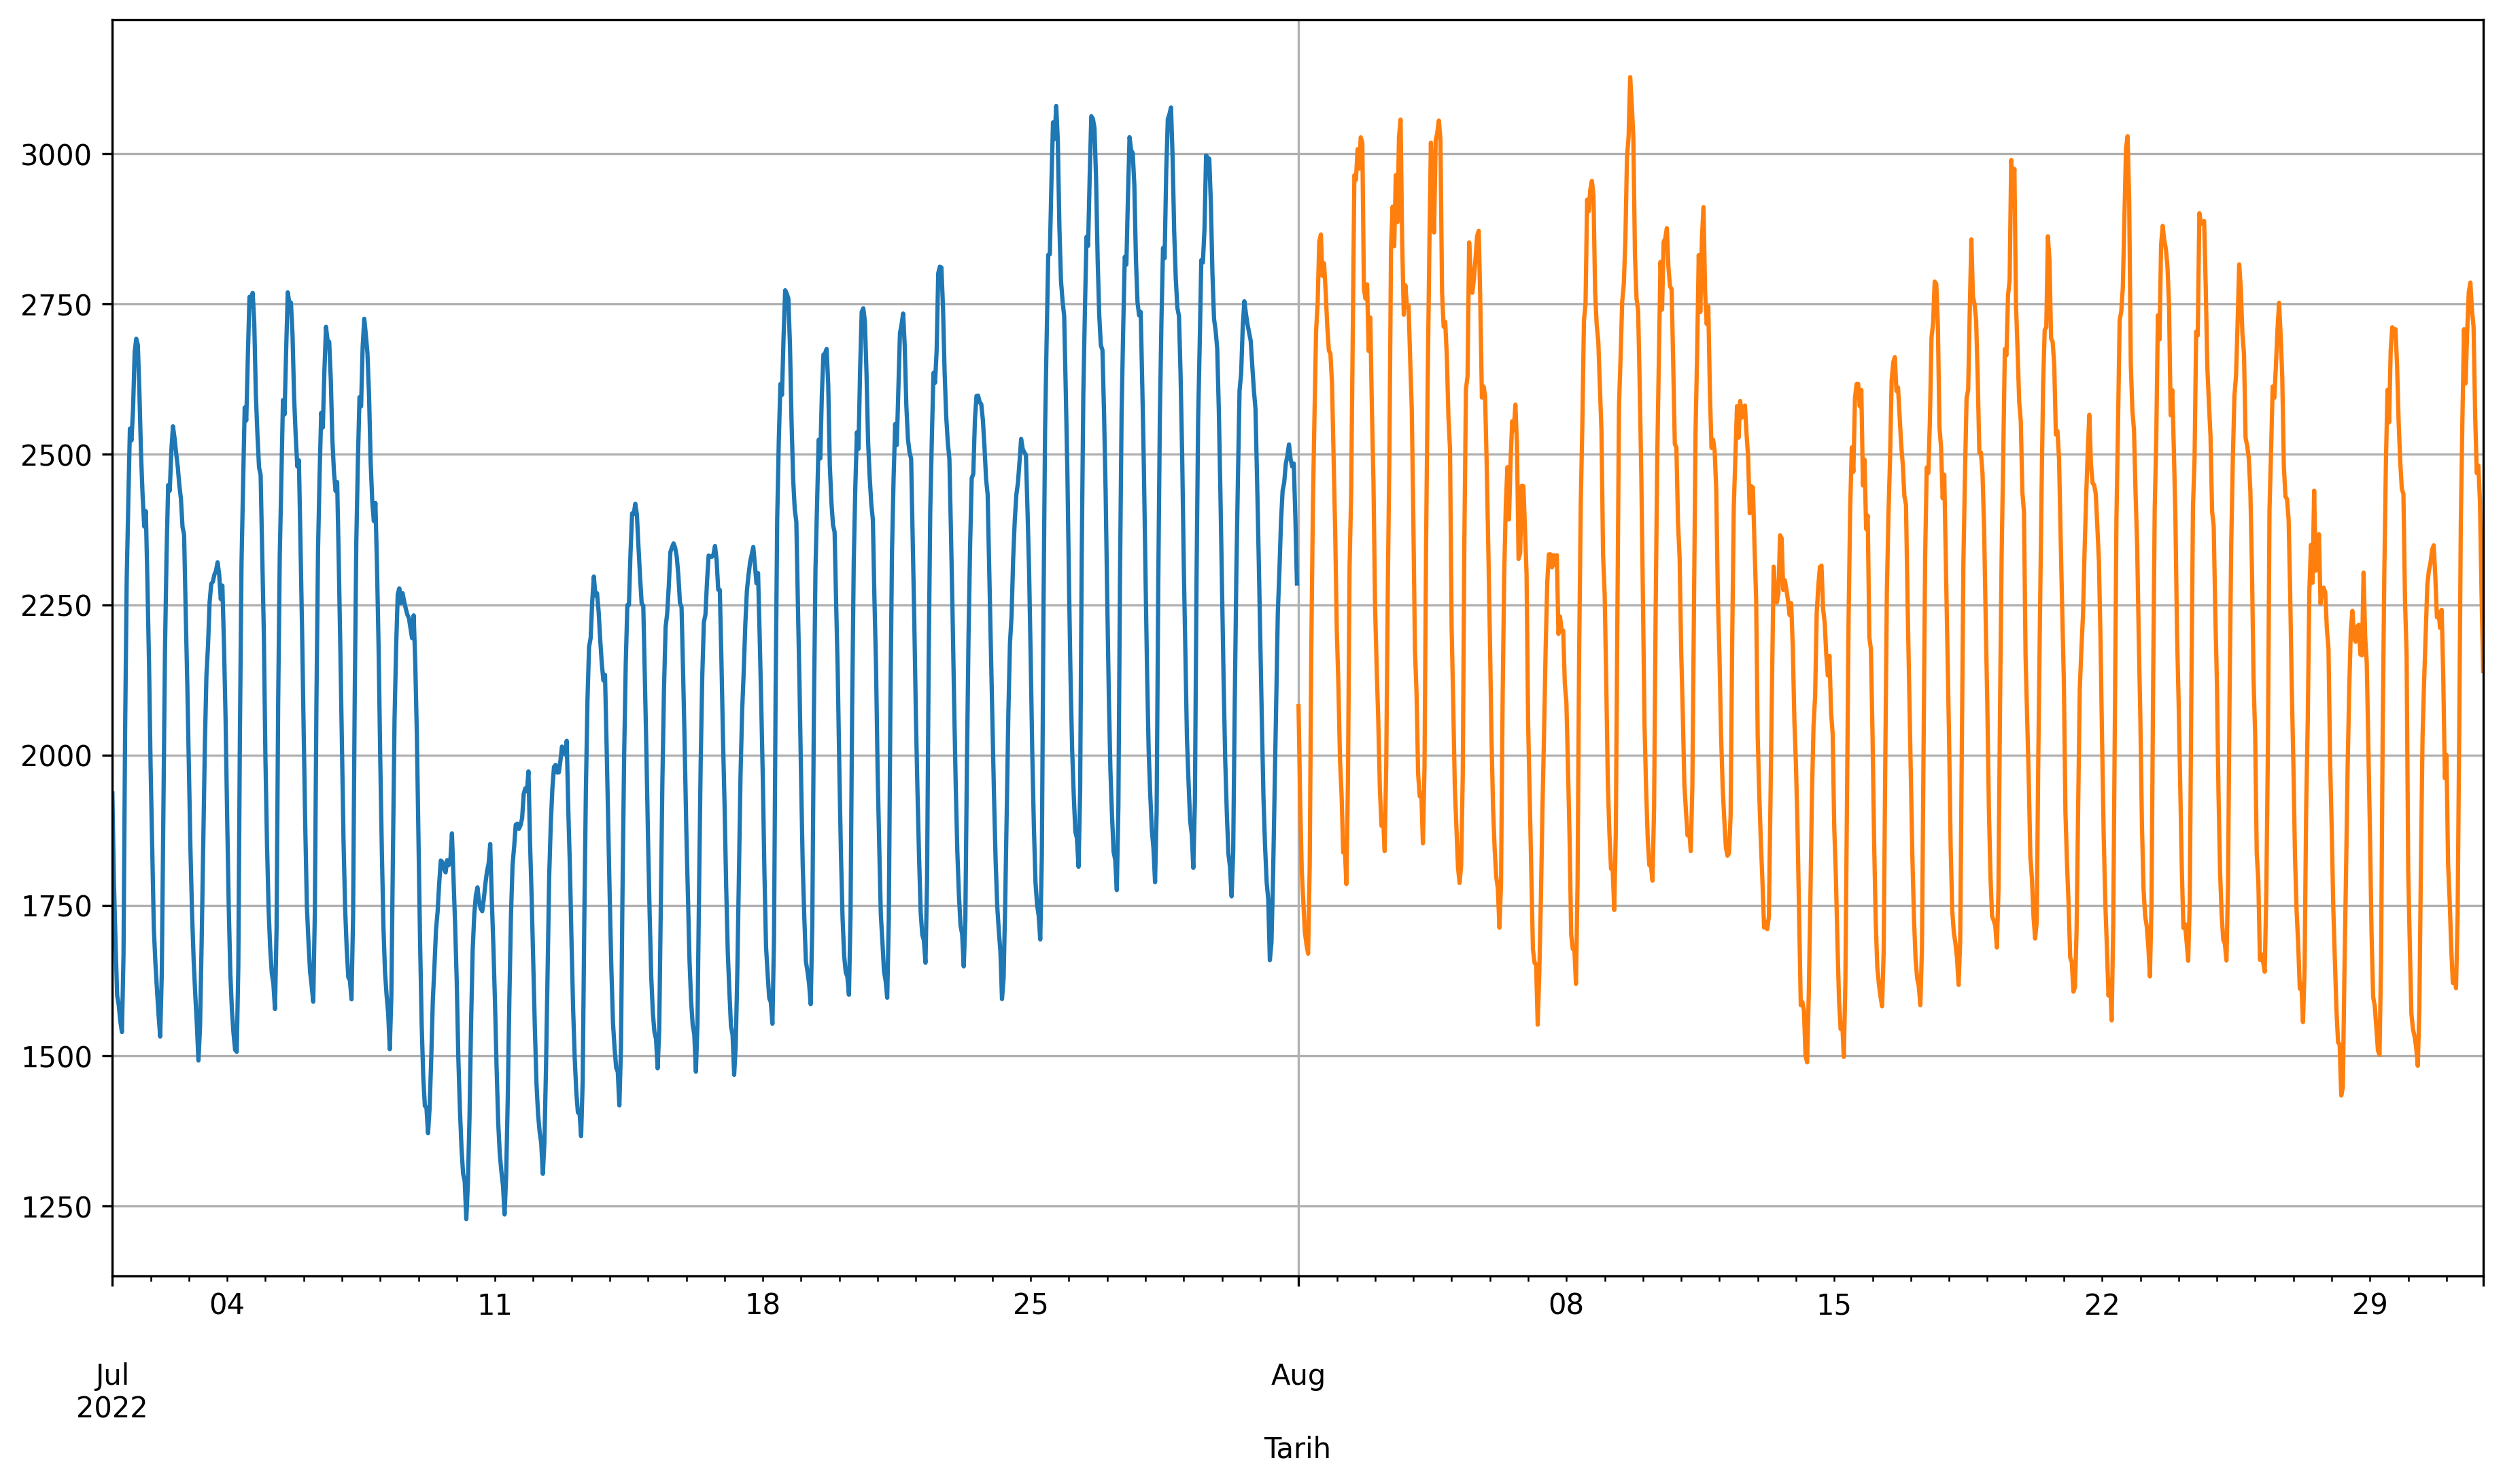

In [256]:
plt.subplots()
train.loc['2022-07':'2022-08']['Dağıtılan Enerji (MWh)'].plot()
test.set_index('Tarih')['Dağıtılan Enerji (MWh)'].plot()
plt.show()

__Modelling the residuals for each İzmir and Manisa__

In [269]:
res_izmir = y_izmir.values - model_izmir.predict(X_izmir)

model_izmir.fit(X_izmir,res_izmir)
test['res_izmir'] = model_izmir.predict(izmir_test_sfs)

[LightGBM] [Warning] feature_fraction is set=0.13536866362065128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13536866362065128
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_gain_to_split is set=0.45842768850988047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.45842768850988047
[LightGBM] [Warning] bagging_fraction is set=0.9140935726842068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9140935726842068
[LightGBM] [Warning] lambda_l1 is set=0.5601979314968509, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5601979314968509
[LightGBM] [Warning] lambda_l2 is set=0.4867955528596627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4867955528596627
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [270]:
res_manisa = y_manisa.values - model_manisa.predict(X_manisa)

model_manisa.fit(X_manisa,res_manisa)
test['res_manisa'] = model_manisa.predict(manisa_test_sfs)

[LightGBM] [Warning] feature_fraction is set=0.34557751606561876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34557751606561876
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_gain_to_split is set=0.2621572127234455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2621572127234455
[LightGBM] [Warning] bagging_fraction is set=0.8374811443349417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8374811443349417
[LightGBM] [Warning] lambda_l1 is set=0.8929778910773379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8929778910773379
[LightGBM] [Warning] lambda_l2 is set=0.9135113529937793, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9135113529937793
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


__Adding the mean of predicted residuals to naively fix if there is any bias__

In [272]:
test.res_izmir.mean()

-0.77168076657127

In [273]:
test.res_manisa.mean()

0.0060068618278629774

In [275]:
test['Dağıtılan Enerji (MWh)'] += test.res_izmir.mean()

In [ ]:
test['Dağıtılan Enerji (MWh)'] += test.res_manisa.mean()

In [279]:
test

,Tarih,Dağıtılan Enerji (MWh),is_test,izmir,manisa,res_izmir,res_manisa
0,2022-08-01 00:00:00,2080.537421,1,1765.005779,316.303323,-6.499237,0.438222
1,2022-08-01 01:00:00,1924.318133,1,1633.328258,291.761556,-12.818246,-3.044861
2,2022-08-01 02:00:00,1808.548553,1,1525.149607,284.170627,3.878625,0.197184
3,2022-08-01 03:00:00,1754.464150,1,1484.843498,270.392332,3.371437,0.195321
4,2022-08-01 04:00:00,1703.514617,1,1438.310255,265.976043,-2.952010,0.267439
...,...,...,...,...,...,...,...
739,2022-08-31 19:00:00,2468.102957,1,2091.853674,377.020963,-3.657780,-0.438749
740,2022-08-31 20:00:00,2480.809964,1,2106.794119,374.787526,15.877890,-0.690986
741,2022-08-31 21:00:00,2420.860475,1,2056.540795,365.091361,9.717008,-0.675199
742,2022-08-31 22:00:00,2266.481293,1,1923.154003,344.098970,3.518289,2.352103


In [281]:
test[['Tarih','Dağıtılan Enerji (MWh)']].to_csv('sfs20_izmir+manisa_each-tuned_LGBM+RESIDUAL_MEAN.csv',index=False)